**Deep Learning for Natural Language Processing: Homework 4**

> Eirini Kolimatsi \
> MSc Computer Science, University of Athens \
>
> **Email**: eirini [dot] kolimatsi [at] di [dot] uoa [dot] gr \
> **Student ID**: 7115112200015

## Libraries & Connection
<a name="libraries"></a>

In [ ]:
# google drive/kaggle connection config
run_in_colab = False

if run_in_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = '/content/drive/My Drive/Colab Notebooks/data/imdb-reviews.csv'
    csv_ready = '/content/drive/My Drive/Colab Notebooks/data/assignment4_processed_2.csv'
else:
    data_path = '/kaggle/input/imdb-custom/imdb-reviews.csv'
    csv_ready = '/kaggle/working/assignment4_processed_2.csv'

In [ ]:
# basic libraries import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gc
import re
import string
from itertools import product
from tqdm import tqdm
tqdm.pandas(position=0, leave=True)

!pip install contractions
import contractions
!pip install pyspellchecker
from spellchecker import SpellChecker

# NLTK imports
import nltk
nltk.download('punkt')
nltk.download("stopwords")
from nltk.corpus import stopwords

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer

# pytorch imports
import torchtext
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F

# huggingface imports
!pip install transformers
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
import logging
# bert config
logging.basicConfig(level=logging.INFO)
bert_model = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.2 MB/s eta 0:00:0000:01:00:01
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# gpu config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on: ", device)

torch.manual_seed(0)
torch.cuda.manual_seed(0)

Running on:  cuda


## Data Loading & Preparation Functions

In [ ]:
# Helpers

# Contractions distionary
contractions_dict = {k.lower(): v for k, v in contractions.contractions_dict.items()}

# Spellchecking: if the typo can't be fixed then do nothing (by default it would return None)
skip_unresolved = lambda fix, typo: fix if fix else typo

def clean_text(text,lowercase=False,remove_contractions=True,remove_html_tags=True,remove_punctuation=False,remove_stopwords=False,reduce_length=True,spellchecking=False):

   lower case
  if lowercase:
    text = text.lower()

  # remove contractions
  if remove_contractions:
    for key in contractions_dict:
              text = text.replace('\b'+key+'\b', contractions_dict[key])

  # Remove html tags
  if remove_html_tags:
    text = re.sub('<[^>]*>', '', text)

  # Remove punctuation
  if remove_punctuation:
    punc = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text) + ' '.join(punc).replace('-', '')
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ')
  
  # Reduce length in cases of multiple letters eg mistaaaaakesssss
  if reduce_length:
    pattern = re.compile(r"(.)\1{2,}")
    text = ' '.join([pattern.sub(r"\1\1", word) for word in text.split()])

  # Remove stopwords
  if remove_stopwords:
    stop = stopwords.words('english')
    stop.extend(['movie','film','one','like','would'])
    text = ' '.join([word for word in text.split() if word not in (stop)])
  
  # Remove multiple spaces
  text = re.sub(r' +',' ',text).strip()

  # Spelling fixes
  if spellchecking:
    spelling = SpellChecker()
    # words with typos are selected taking into consideration the embeddings
    # if a word is a typo but exists in glove embeddings then it isn't fixed
    words = text.split()
    typo_words = {tw:spelling.correction(tw) for tw in spelling.unknown(words) if tw not in glove.itos}
    text = ' '.join([skip_unresolved(spelling.correction(word),word) if word in typo_words else word for word in words])

  return text.strip()

# Load and prep dataset
def prep_data(data_path):
  df = pd.read_csv(data_path, sep='\t')
  df['review'] = df['review'].progress_apply(clean_text, spellchecking=False)

  df.drop(['url'], axis=1, inplace=True)

  df.loc[df['rating'] <= 4, 'rating'] = 0
  df.loc[df['rating'] >= 7, 'rating'] = 1
  return df

In [ ]:
BATCH_SIZE = 10

# BERT tokenization and dataloaders
def apply_tokenization(dfx, dfy, shuffle=True):

  MAX_SEQ_LEN = 235
  token_id = []
  attention_masks = []
  
  # loop through all reviews to tokenize them
  for x in dfx.to_list():
    encoded_x = tokenizer.encode_plus(
                        x,
                        add_special_tokens = True,
                        truncation=True,
                        max_length = MAX_SEQ_LEN,
                        pad_to_max_length=True,
                        return_attention_mask = True,
                        return_tensors = 'pt')
    
    
    token_id.append(encoded_x['input_ids']) 
    attention_masks.append(encoded_x['attention_mask'])
    
  # prepare tensors for the dataset
  token_id = torch.cat(token_id, dim = 0)
  attention_masks = torch.cat(attention_masks, dim = 0)
  labels = torch.tensor(dfy.to_list())
    
  # create tensor dataset
  dataset = TensorDataset(token_id, attention_masks, labels)
  
  # create dataloader
  dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=shuffle)
  return dataset, dataloader

## Data Loading

In [ ]:
# basic cleaning and data loading
df = prep_data(data_path)

100%|██████████| 45008/45008 [00:30<00:00, 1453.84it/s]


In [ ]:
# Check reviews length
print('Mean review length:',np.mean(df['review'].apply(str.split).apply(len)))
print('Median review length:',np.median(df['review'].apply(str.split).apply(len)))
print('Max review length:',np.max(df['review'].apply(str.split).apply(len)))
print('Min review length:',np.min(df['review'].apply(str.split).apply(len)))

Mean review length: 228.48806878777106
Median review length: 171.0
Max review length: 2450
Min review length: 6


In [ ]:
# Check class balance
df['rating'].value_counts()

1.0    22508
0.0    22500
Name: rating, dtype: int64

In [ ]:
# Select x and y
X = df['review']
y = df['rating']

# Split dataset to train and test set. 90-10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Split train dataset to train and validation set. 80-10-10
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/0.8, random_state=42, stratify=y_train)

print("Shape of x_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_val:  ", X_val.shape)
print("Shape of y_val:  ", y_val.shape)
print("Shape of x_test:  ", X_test.shape)
print("Shape of y_test:  ", y_test.shape)
print('---------------')
print('class counts of y_train: \n', y_train.value_counts())
print('class counts of y_val: \n', y_val.value_counts())
print('class counts of y_test: \n', y_test.value_counts())

Shape of x_train:  (35443,)
Shape of y_train:  (35443,)
Shape of x_val:   (5064,)
Shape of y_val:   (5064,)
Shape of x_test:   (4501,)
Shape of y_test:   (4501,)
---------------
class counts of y_train: 
 1.0    17725
0.0    17718
Name: rating, dtype: int64
class counts of y_val: 
 1.0    2532
0.0    2532
Name: rating, dtype: int64
class counts of y_test: 
 1.0    2251
0.0    2250
Name: rating, dtype: int64


In [ ]:
print('train dataloader')
train_dataset, train_dataloader = apply_tokenization(X_train, y_train)
print('test dataloader')
test_dataset, test_dataloader = apply_tokenization(X_test, y_test, shuffle=False)
print('val dataloader')
val_dataset, val_dataloader = apply_tokenization(X_val, y_val, shuffle=False)

train


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2345: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


test


# Model

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, hidden_layers=50, dropout_p=None, freeze_bert=False):
        super(SentimentClassifier, self).__init__()
        D_in, H, D_out = 768, hidden_layers, 1

        # BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Feed Forward Classifier
        if dropout_p is None:
            self.classifier = nn.Sequential(
                nn.Linear(D_in, H),
                nn.ReLU(),
                nn.Linear(H, D_out)
            )
        else:
            self.classifier = nn.Sequential(
                nn.Linear(D_in, H),
                nn.ReLU(),
                nn.Dropout(dropout_p),
                nn.Linear(H, D_out)
            )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Pass input from BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state for CLS
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Pass from the classifier to get the logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

## Training Functions

In [ ]:
# train the model
def train(model, optimizer, scheduler, criterion, train_dataloader):
      tr_loss, tr_accuracy = [], []
      
      model.train()

      for step, batch in enumerate(train_dataloader):
          input_ids, attn_mask, labels = tuple(t.to(device) for t in batch)

          # Zero out any previously calculated gradients
          model.zero_grad()

          # Get logits & compute loss
          logits = model(input_ids, attn_mask)
          loss = criterion(logits.view(-1,), labels)
          tr_loss.append(loss.item())
            
          loss.backward()

          # Gradient Clipping
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
          optimizer.step()
          scheduler.step()

          # Predictions
          preds = torch.argmax(logits, dim=1).flatten()

          # Accuracy rate
          accuracy = torch.sum(((logits.squeeze() > 0.0) == labels.squeeze()).float()).item()/len(input_ids)*100
          tr_accuracy.append(accuracy)
        
      avg_train_loss = np.mean(tr_loss)
      avg_accuracy = np.mean(tr_accuracy)

      return avg_train_loss, avg_accuracy

In [ ]:
# validate the model
def validate(model, criterion, val_dataloader):
    val_accuracy = []
    val_loss = []
    
    model.eval()
    
    for batch in val_dataloader:
        input_ids, attn_mask, labels = tuple(t.to(device) for t in batch)
        
        # Get logits & compute loss
        with torch.no_grad():
            logits = model(input_ids, attn_mask)

        loss = criterion(logits.view(-1,), labels)
        val_loss.append(loss.item())

        # Predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Accuracy rate
        accuracy = torch.sum(((logits.squeeze() > 0.0) == labels.squeeze()).float()).item()/len(input_ids)*100
        val_accuracy.append(accuracy)
    
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
# test the model
def test(model, test_dataloader):
    all_preds, all_true = [], []
    score_accuracy = []
    score_f1 = []
    score_precision = []
    score_recall = []
    
    model.eval()
    
    for batch in test_dataloader:
        input_ids, attn_mask, labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(input_ids, attn_mask)

        # Predictions
        preds = (logits.view(-1,).squeeze()>0.0)

        # Metrics
        try:
            score_f1.append(f1_score(labels.cpu().numpy(),preds.cpu().detach().numpy(),average='micro'))
            score_accuracy.append(accuracy_score(labels.cpu().numpy(),preds.cpu().detach().numpy()))
            score_recall.append(recall_score(labels.cpu().numpy(),preds.cpu().detach().numpy(),average='micro'))
            score_precision.append(precision_score(labels.cpu().numpy(),preds.cpu().detach().numpy(),average='micro'))
        except TypeError:
            list_labels, list_preds = [labels.cpu().numpy().tolist()], [preds.cpu().numpy().tolist()]
            score_f1.append(f1_score(list_labels, list_preds,average='micro'))
            score_accuracy.append(accuracy_score(list_labels, list_preds))
            score_recall.append(recall_score(list_labels, list_preds,average='micro'))
            score_precision.append(precision_score(list_labels, list_preds,average='micro'))
  
        all_preds.append(preds.view(-1,))
        all_true.append(labels.view(-1,))

    print("F1:        {:.6f}".format(np.mean(score_f1)*100))
    print("Recall:    {:.6f}".format(np.mean(score_recall)*100))
    print("Precision: {:.6f}".format(np.mean(score_precision)*100))
    print("Accuracy:  {:.6f}".format(np.mean(score_accuracy)*100))
    
    # Plots confusionn Matrix and ROC curve
    plot_confusion(torch.cat(all_preds).cpu().numpy(),torch.cat(all_true).cpu().numpy())
    plot_roc(torch.cat(all_preds).cpu().numpy(),torch.cat(all_true).cpu().numpy())

    return all_preds, all_true

In [ ]:
# Plot learning curves
def plot_learning(train_loss, val_loss, epoch_tr_acc, epoch_vl_acc, num_epochs):
  X_values = np.arange(num_epochs)

  # Loss vs Epochs
  fig = plt.figure(figsize=(11,5))
  ax1 = fig.add_subplot(121)
  ax1.plot(X_values, train_loss, label= 'train')
  ax1.plot(X_values, val_loss, label= 'validation')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  plt.title('Training & Validation Loss')
  ax1.legend()

  # Accuracy vs Epochs
  ax2 = fig.add_subplot(122)
  ax2.plot(X_values, epoch_tr_acc, label= 'train')
  ax2.plot(X_values, epoch_vl_acc, label= 'validation')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  plt.title('Training & Validation Accuracy')
  ax2.legend()

  plt.show()

In [ ]:
# Plot Confusion Matrix
def plot_confusion(y_pred, y_true):
  cm = confusion_matrix(y_pred, y_true,labels=[0,1])
  disp = ConfusionMatrixDisplay(cm, display_labels=['Negative','Positive']).plot()

  plt.show()

In [ ]:
# Plot ROC Curve
def plot_roc(y_pred, y_true):
  fpr, tpr, threshold = roc_curve(y_pred, y_true)
  roc_auc = auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
    
  plt.show()

In [ ]:
# Run model training
def run(model, optimizer, scheduler, criterion, 
        train_dataloader, val_dataloader, test_dataloader,
        epochs=4):
    
  val_loss_all, tr_loss_all = [], []
  val_acc_all, tr_acc_all = [], []
    
  print(f"{'Epoch':^7} | {'Train Loss':^10} | {'Train Acc':^10} | {'Val Loss':^10} | {'Val Acc':^10}")
  for e in range(epochs):
    # Train
    epoch_tr_loss, epoch_tr_acc = train(model, optimizer, scheduler, criterion, train_dataloader)
    #Validate
    epoch_vl_loss, epoch_vl_acc = validate(model, criterion, val_dataloader)

    tr_loss_all.append(epoch_tr_loss)
    tr_acc_all.append(epoch_tr_acc)
    val_loss_all.append(epoch_vl_loss)
    val_acc_all.append(epoch_vl_acc)
    print(f"{e + 1:^7} | {epoch_tr_loss:^10.6f} | {epoch_tr_acc:^10.2f} | {epoch_vl_loss:^10.6f} | {epoch_vl_acc:^10.2f}")
  
  #Test
  p, t = test(model, test_dataloader)
  # Plot learning curves
  plot_learning(tr_loss_all, val_loss_all, tr_acc_all, val_acc_all, epochs)
    
  return p,t

# Experiments

### 1st Experiment: BERT + Simple Feed Forward without Dropout Layer

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  | Train Loss | Train Acc  |  Val Loss  |  Val Acc  
   1    |  0.301439  |   88.72    |  0.253312  |   90.79   
   2    |  0.155878  |   95.85    |  0.304109  |   92.74   
F1:        92.660754
Recall:    92.660754
Precision: 92.660754
Accuracy:  92.660754


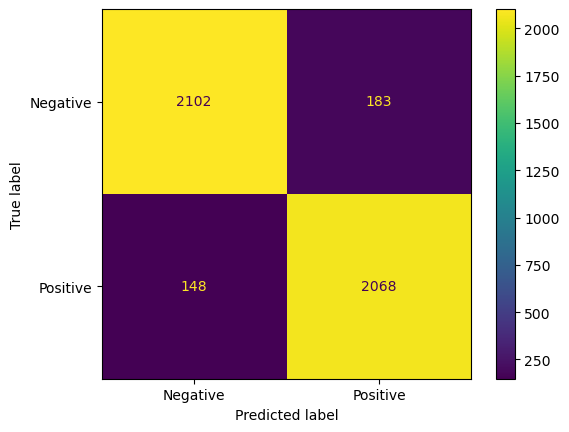

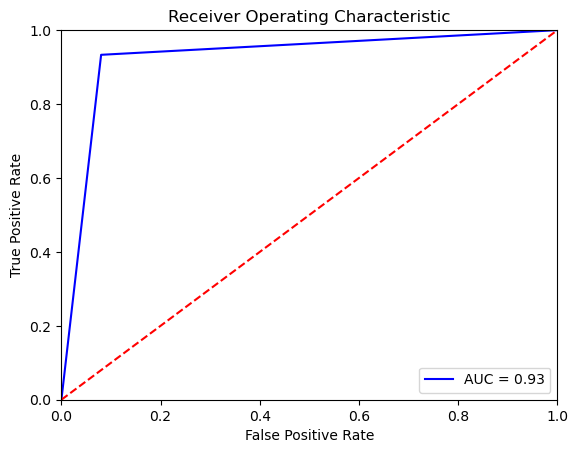

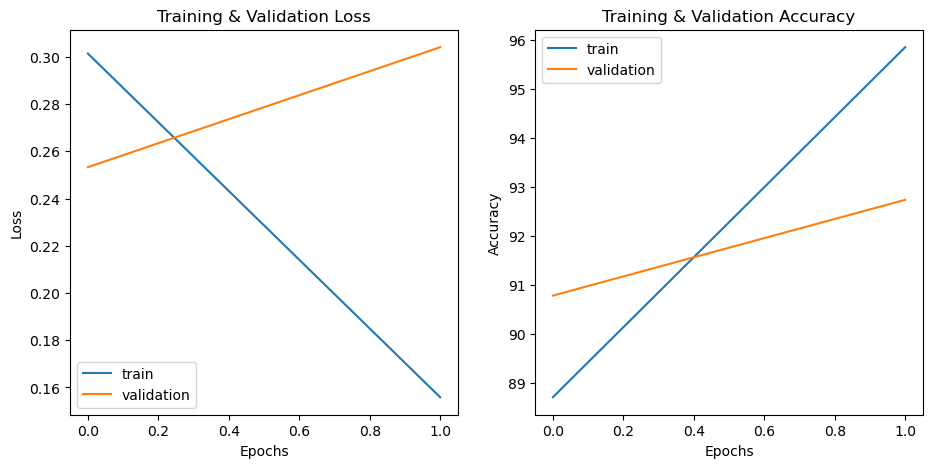

In [ ]:
sentiment_classifier = SentimentClassifier(freeze_bert=False).to(device)

# Optimizer
optimizer = torch.optim.AdamW(sentiment_classifier.parameters(),
                              lr=5e-5,    # Default learning rate
                              eps=1e-8    # Default epsilon value
                              )
n_epochs = 2
total_steps = len(train_dataloader) * n_epochs

# LR Scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, # Default value
                                            num_training_steps=total_steps)

# Loss function
criterion = nn.BCEWithLogitsLoss()

p,t=run(sentiment_classifier, optimizer, scheduler, criterion, 
        train_dataloader, val_dataloader, test_dataloader, epochs = n_epochs)

In [ ]:
model1_all_preds, model1_all_true = torch.cat(p).cpu().numpy(),torch.cat(t).cpu().numpy()

print("Model 1: Final Results")
print("F1:        {:.6f}".format(f1_score(model1_all_preds, model1_all_true)*100))
print("Recall:    {:.6f}".format(recall_score(model1_all_preds, model1_all_true)*100))
print("Precision: {:.6f}".format(precision_score(model1_all_preds, model1_all_true)*100))
print("Accuracy:  {:.6f}".format(accuracy_score(model1_all_preds, model1_all_true)*100))

Model 1: Final Results
F1:        92.590105
Recall:    93.321300
Precision: 91.870280
Accuracy:  92.646079


In [ ]:
torch.save(sentiment_classifier, 'imdb_bert_model.pt')

### 2nd Experiment: BERT + Simple Feed Forward with Dropout Layer

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  | Train Loss | Train Acc  |  Val Loss  |  Val Acc  
   1    |  0.321313  |   88.49    |  0.244726  |   92.45   
   2    |  0.172616  |   95.78    |  0.297990  |   93.18   
F1:        92.793792
Recall:    92.793792
Precision: 92.793792
Accuracy:  92.793792


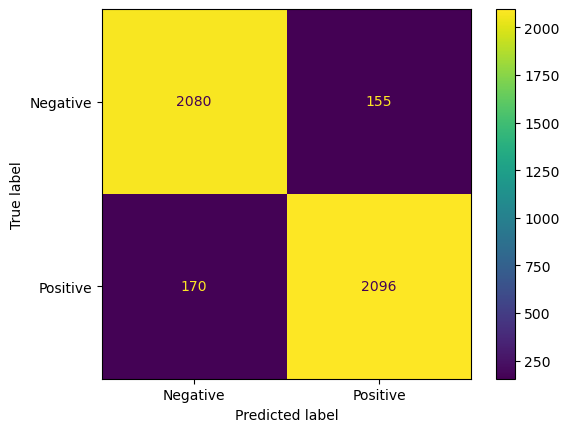

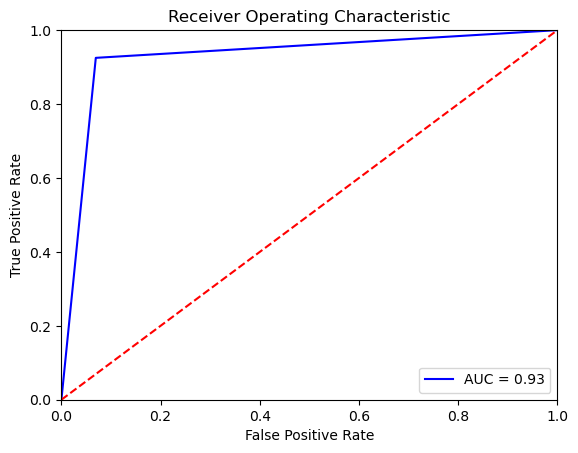

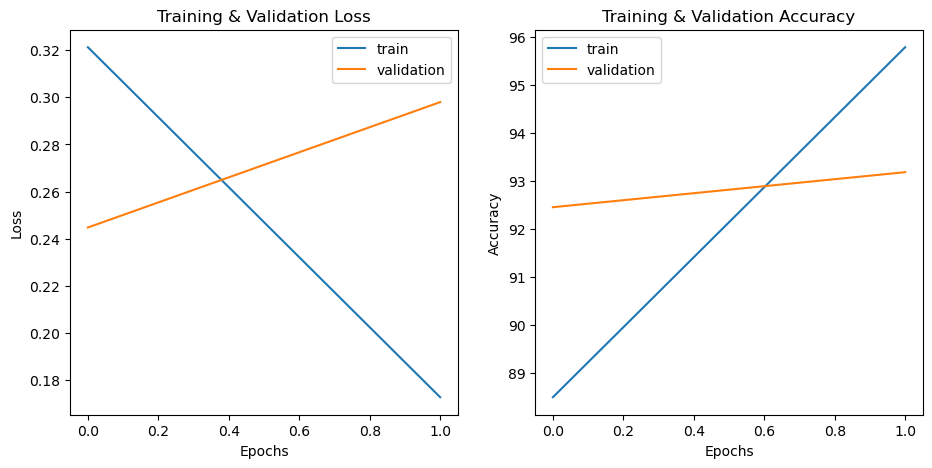

In [ ]:
sentiment_classifier2 = SentimentClassifier(dropout_p=0.5, freeze_bert=False).to(device)

# Create the optimizer
optimizer = torch.optim.AdamW(sentiment_classifier2.parameters(),
                              lr=5e-5,    # Default learning rate
                              eps=1e-8    # Default epsilon value
                              )
n_epochs = 2
# Total number of training steps
total_steps = len(train_dataloader) * n_epochs

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, # Default value
                                            num_training_steps=total_steps)

criterion = nn.BCEWithLogitsLoss()

p2,t2=run(sentiment_classifier2, optimizer, scheduler, criterion, 
        train_dataloader, val_dataloader, test_dataloader, epochs = n_epochs)

In [ ]:
model2_all_preds, model2_all_true = torch.cat(p2).cpu().numpy(),torch.cat(t2).cpu().numpy()

print("Model 2: Final Results")
print("F1:        {:.6f}".format(f1_score(model2_all_preds, model2_all_true)*100))
print("Recall:    {:.6f}".format(recall_score(model2_all_preds, model2_all_true)*100))
print("Precision: {:.6f}".format(precision_score(model2_all_preds, model2_all_true)*100))
print("Accuracy:  {:.6f}".format(accuracy_score(model2_all_preds, model2_all_true)*100))

Model 2: Final Results
F1:        92.804959
Recall:    92.497793
Precision: 93.114171
Accuracy:  92.779382


In [ ]:
torch.save(sentiment_classifier, 'imdb_bert_model_dropout.pt')

## Test the model

To run the model on other data, the following steps should be done:


1.   Load libraries/functions required
  

*   Run the section Libraries & Connnection
* Run the sectionn Data Loading & Preparation Functions
* Run the section Training Functions



2.   Load data & Model
* The model can be downloaded from https://drive.google.com/file/d/1r94InfjTNMP2U-1l30FoebwVP0K8i7em/view?usp=share_link

3.   Run predictions



In [ ]:
# Try it with hidden test data
path_to_data = 'path/to/test/data'
path_to_model = 'path/imdb_bert_model_dropout.pt'

# Data Preparation
BATCH_SIZE = 10

df = prep_data(path_to_data)
_, hidden_test_loader = apply_tokenization(df['review'],df['rating'],shuffle=False)

# Load Model
final_model = torch.load(path_to_model) 
final_model.eval()

# Predictions & Results
test(final_model,hidden_test_loader)

## References

*   Pytorch & Hugging Face Documentation
*   https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-analysis-train-model

